<a href="https://colab.research.google.com/github/asravankumar/END2.0/blob/master/session_6/encoder_decoder_tweets_sentiment_2_lstm_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import pandas as pd

df = pd.read_csv("/content/tweets.csv")
df.head()

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [2]:
df.shape

(1364, 2)

In [3]:
df.labels.value_counts()

0    931
1    352
2     81
Name: labels, dtype: int64

In [4]:
import random
import torch, torchtext
from torchtext import data

In [5]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [6]:
Tweet = torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [7]:
fields = [('tweet', Tweet), ('label', Label)]

In [8]:
example = [torchtext.legacy.data.Example.fromlist([df.tweets[i],df.labels[i]], fields) for i in range(df.shape[0])] 

In [9]:
twitterDataset = torchtext.legacy.data.Dataset(example, fields)

In [10]:
(train, valid) = twitterDataset.split(split_ratio=[85, 15], random_state = random.seed(SEED))

In [11]:
len(train), len(valid)

(1159, 205)

In [12]:
vars(train.examples[11])

{'label': 1,
 'tweet': ['@sweetbay',
  'That',
  'was',
  'Paul',
  'Ryan',
  "'s",
  'budget',
  '.',
  'How',
  'did',
  'Obama',
  "'s",
  'budget',
  'do',
  '?',
  'Getting',
  'educated',
  'on',
  'the',
  'facts',
  'is',
  'the',
  'first',
  'step',
  'in',
  'losing',
  'that',
  'liberalism',
  '!']}

In [13]:
Tweet.build_vocab(train)
Label.build_vocab(train)

In [14]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4651
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1069), (':', 783), ('#', 780), ('.', 761), (',', 598), ('"', 550), ('the', 542), ('RT', 516), ('?', 419), ('to', 400)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [37]:
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train, valid), batch_size = 5, 
                                                            sort_key = lambda x: len(x.tweet),
                                                            sort_within_batch=True, device = device)

In [ ]:
next(iter(train_iterator))
#len(train.examples[11].tweet)


[torchtext.legacy.data.batch.Batch of size 5]
	[.tweet]:('[torch.LongTensor of size 5x28]', '[torch.LongTensor of size 5]')
	[.label]:[torch.LongTensor of size 5]

In [38]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

In [46]:
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    # Encoder class which accepts a sequence(tweet) and converts it into a context vector.
    super().__init__()

    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # RNN Layer for encoding
    self.rnn_layer = nn.RNN(embedding_dim,
                          hidden_dim,
                          batch_first=True)
    
  def forward(self, text, text_lengths):
    #print("inside encoder")
    # text = [batch size, sent_length]
    embedded_text         = self.embedding(text)

    #print("embedded text dimension", embedded_text.shape)
    # embedded = [batch size, sent_len, emb dim]

    # packed sequence
    packed_embedded_text  = nn.utils.rnn.pack_padded_sequence(embedded_text,
                                                        text_lengths.cpu(),
                                                        batch_first=True)
    #print("packed embedded text dimension", packed_embedded_text.data.shape)

    # input sequence to the rnn layer 
    encoder_output, hidden   = self.rnn_layer(packed_embedded_text)
    # rnn output in packed format which contains outputs at every sequence.
    # the hidden will be of last state only.
    # hidden = [1 , batch_size, hidden_dim]
    # Note that, the hidden tensor will not be in the batch_first = True shape. Only the output tensor will be in batch_first if it is set to true.
    # print("encoder output dimension", encoder_output.data.shape)
    #print("hidden dimension", hidden.shape)
    #print("hidden vector", hidden)

    # unpack the encoder rnn output 
    encoder_output, encoder_output_lengths = nn.utils.rnn.pad_packed_sequence(encoder_output, batch_first=True)
    # will be in batch_first = True shape
    # encoder_output = [batch_size, sent_len, hidden_dim]
    #print("encoder_output after pad packed dimension", encoder_output.shape)
    #print("--------------------------------------------------")

    # here returning the output at all states.
    # and the last hidden vector which is the SINGLE context vector for the input sequence. 
    return(encoder_output, hidden)

class Decoder(nn.Module):
  def __init__(self, encoder_output_dim, hidden_dim):
    super().__init__()

    # lstm layer as part of decoder.
    # the encoder emits a hidden vector with one sequence. Hence, lstm is here for once in the pipeline.

    self.decoder = nn.LSTM(encoder_output_dim, 
                       hidden_dim,  
                       batch_first=True)
    self.decoder2 = nn.LSTM(hidden_dim, 
                       hidden_dim,  
                       batch_first=True)

  def forward(self, single_vector):
    # Here single_vector is the hidden vector from the encoder.
    # single_vector = [batch_size, 1, hidden_dim]
    #print("inside decoder")
    #print("encoder output dimension", single_vector.shape)

    # encoder_output = encoder_output.squeeze(0).unsqueeze(1)
    # encoder_output
    output, (hidden_vector, cell_vector) = self.decoder(single_vector)
    # hidden_vector is the decoded vector which is input to the fully connected layer.
    # hidden_vector = [1, batch_size, hidden_dim]
    #print("decoded output dimension", output.shape)
    #print("decoded hidden vector dimension", hidden_vector.shape)
    #print("decoded cell vector dimension", cell_vector.shape)
    #print("-----------------")
    output2, (hidden_vector2, cell_vector2) = self.decoder(output, (hidden_vector, cell_vector))
    #print("decoded output2 dimension", output2.shape)
    #print("decoded hidden2 vector dimension", hidden_vector.shape)
    #print("decoded cell2 vector dimension", cell_vector.shape)
    #print("---------------------------------------------------")
    return(output2, hidden_vector2)

class EncoderDecoderClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(EncoderDecoderClassifier, self).__init__()

    self.encoder = Encoder(vocab_size, embedding_dim, hidden_dim)
    self.decoder = Decoder(hidden_dim, hidden_dim)
    self.fc      = nn.Linear(hidden_dim, output_dim)

  def forward(self, text, text_lengths):
    # Encoder encodes using an rnn.
    encoder_output, encoder_hidden = self.encoder(text, text_lengths)

    # the hidden vector emitted by rnn is not in batch_first=True shape. Hence converting.
    #print("encoder hidden dimension", encoder_hidden.shape)
    # encoder_hidden = [1, batch_size, hidden_dim]
    encoder_hidden = encoder_hidden.squeeze(0).unsqueeze(1)
    #print("encoder output dimension after sqeeze", encoder_hidden.shape)
    # AFter reshaping
    # encoder_hidden = [batch_size, 1, hidden_dim]
    
    # Decode the input encoded single vector.
    decoder_output, decoder_hidden = self.decoder(encoder_hidden)

    # the hidden vector emitted by the decoder is in the batch_first=False shape. Hence convert it to shape for linear layer.
    decoder_hidden = decoder_hidden.squeeze(0) #.unsqueeze(1)
    # input to fully connected layer dimension = [batch_size, hidden_dim]
    #print("input to fully connected layer", decoder_hidden.shape)
    dense_outputs = self.fc(decoder_hidden)
    # fully connected layer output = [batch_size, output_dim]
    #print("dense outputs", dense_outputs.shape)
    final_output = F.softmax(dense_outputs, dim=0)
    #print("final output", final_output.shape)
    return(final_output, encoder_output, encoder_hidden, decoder_output)

In [47]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.2

# Instantiate the model
model = EncoderDecoderClassifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes)
#model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [48]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

EncoderDecoderClassifier(
  (encoder): Encoder(
    (embedding): Embedding(4651, 300)
    (rnn_layer): RNN(300, 100, batch_first=True)
  )
  (decoder): Decoder(
    (decoder): LSTM(100, 100, batch_first=True)
    (decoder2): LSTM(100, 100, batch_first=True)
  )
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
The model has 1,597,403 trainable parameters


In [36]:
batch = next(iter(train_iterator))
tweet, tweet_lengths = batch.tweet
print("tweet", tweet)
print("tweet lenghts", tweet_lengths)
model = model.to(device)
final_output, encoder_output, encoder_hidden, decoder_output = model(tweet, tweet_lengths)
print("final_output", final_output)
print("final output dimensions", final_output.shape)
print("---------------------------")

print("batch label", batch.label)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
loss = criterion(final_output, batch.label)
print("loss", loss)

tweet tensor([[   2,  363,    8,  110,   87,  263,  352,  205,    6,  368,   20,  185,
          350,   20,  345,   13,   26, 3846,    4,  391,    4,  172],
        [   2,   12,  163,    3,   47,  558,  567,  426,  553,  549,  163,   47,
           20,  475, 3954,   22,   27, 3298,  572,   12,  126,    5],
        [1400,  878, 1554, 2298,  124,   33,    2,    6, 2375,    6, 2807, 3270,
         3208, 1620,    5,   33,  370,   71,    8,  399, 4329,   10],
        [  23,  600,  280,   16,   14,  760, 1096, 1136,    7,    2,  879,  969,
            7,  204,  128,  171,   73,   93,    2,  782,   20,  692],
        [   2,  363,    8,  110,   87,  263,  352,  205,    6,  368,   20,  185,
          350,   20,  345,   13,   26, 3870,    4,  391,    4,  172]])
tweet lenghts tensor([22, 22, 22, 22, 22])
inside decoder
encoder output dimension torch.Size([5, 1, 100])
decoded output dimension torch.Size([5, 1, 100])
decoded hidden vector dimension torch.Size([1, 5, 100])
decoded cell vector dimens

In [49]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [50]:
def train_model(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweet  
        
        # convert to 1D tensor
        predictions, encoder_output, encoder_hidden, decoder_output = model(tweet, tweet_lengths)
        predictions = predictions.squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [51]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweet
            
            # convert to 1d tensor
            #predictions = model(tweet, tweet_lengths).squeeze()
            
            predictions, encoder_output, encoder_hidden, decoder_output = model(tweet, tweet_lengths)
            predictions = predictions.squeeze()  
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [52]:
N_EPOCHS = 50
best_valid_loss = float('inf')
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.095 | Train Acc: 50.34%
	 Val. Loss: 1.092 |  Val. Acc: 57.56% 

	Train Loss: 1.071 | Train Acc: 60.43%
	 Val. Loss: 1.055 |  Val. Acc: 60.98% 

	Train Loss: 1.027 | Train Acc: 66.10%
	 Val. Loss: 1.037 |  Val. Acc: 60.49% 

	Train Loss: 1.003 | Train Acc: 70.93%
	 Val. Loss: 1.040 |  Val. Acc: 61.46% 

	Train Loss: 0.981 | Train Acc: 72.16%
	 Val. Loss: 1.041 |  Val. Acc: 57.07% 

	Train Loss: 0.978 | Train Acc: 74.63%
	 Val. Loss: 1.035 |  Val. Acc: 59.02% 

	Train Loss: 0.958 | Train Acc: 78.86%
	 Val. Loss: 1.031 |  Val. Acc: 62.93% 

	Train Loss: 0.955 | Train Acc: 79.74%
	 Val. Loss: 1.033 |  Val. Acc: 61.95% 

	Train Loss: 0.953 | Train Acc: 78.10%
	 Val. Loss: 1.035 |  Val. Acc: 64.39% 

	Train Loss: 0.946 | Train Acc: 80.09%
	 Val. Loss: 1.033 |  Val. Acc: 63.90% 

	Train Loss: 0.939 | Train Acc: 82.84%
	 Val. Loss: 1.031 |  Val. Acc: 63.90% 

	Train Loss: 0.939 | Train Acc: 81.12%
	 Val. Loss: 1.028 |  Val. Acc: 64.88% 

	Train Loss: 0.938 | Train Acc: 83.88%
	

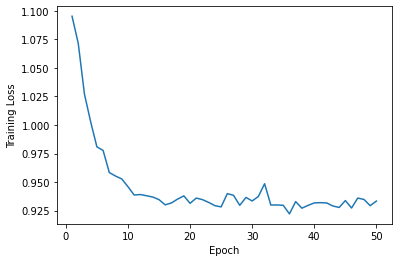

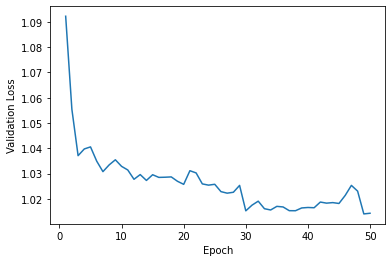

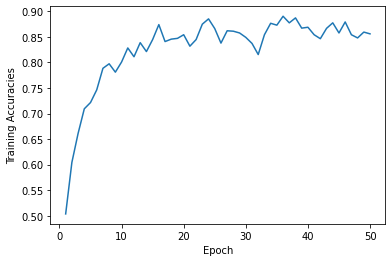

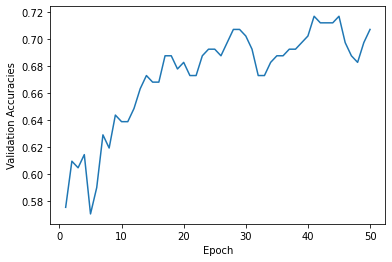

In [53]:
import matplotlib.pyplot as plt

plt.plot(list(range(1, len(train_losses) + 1)), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('training_loss.png')
plt.show()

plt.plot(list(range(1, len(valid_losses) + 1)), valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('valid_loss.png')
plt.show()

plt.plot(list(range(1, len(train_accuracies) + 1)), train_accuracies, label="Training Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracies")
plt.savefig('training_accuracies.png')
plt.show()

plt.plot(list(range(1, len(valid_accuracies) + 1)), valid_accuracies, label="Valid Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracies")
plt.savefig('validation_accuracies.png')
plt.show()

In [54]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet, print_vectors=False):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]      
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction, encoder_output, encoder_hidden, decoder_output = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    if print_vectors:
      print("Encoder output after each token in the sequence:")
      for i in range(encoder_output.shape[1]):
        print("input word: \"" + tokenized[i] + "\"")
        print("encoding output vector:", encoder_output[0][i])
        print("--------")
      print("-----------------------------------------------")
      print("The Encoder final state hidden vector which is the single vector for sequence:")
      print("single vector", encoder_hidden)
      print("-----------------------------------------------")
      print("Decoder output after 1st step")
      print("decoder_output", decoder_output)
      print("-----------------------------------------------")
      #print("encoder_output", encoder_output.shape)
      #print("single vector", encoder_hidden.shape)
      #print("decoder_output", decoder_output.shape)
    return categories[pred.item()]

In [55]:
classify_tweet("#edshow Whenever Obama tells the truth about the Gop, they boo hoo hoo and call him a bully.", True)

Encoder output after each token in the sequence:
input word: "#"
encoding output vector: tensor([ 0.8814, -0.5904,  0.6300,  0.7274, -0.8913,  0.7539, -0.7159,  0.4186,
         0.7341, -0.1098, -0.6540,  0.4365,  0.5824, -0.9359, -0.2081,  0.8914,
         0.8373,  0.6788,  0.7856,  0.2860,  0.6474, -0.7796, -0.6518,  0.7033,
         0.9205,  0.0343,  0.1441, -0.8543, -0.3003,  0.9494,  0.6035, -0.6866,
        -0.8248,  0.7784,  0.5229,  0.2161, -0.9756, -0.8881,  0.6573, -0.4417,
        -0.9203, -0.6000,  0.6708,  0.8455, -0.1233,  0.5348, -0.8098,  0.8841,
        -0.2997,  0.9122, -0.8517, -0.9686,  0.6891,  0.8770, -0.3420, -0.1710,
         0.1252, -0.8752, -0.5909, -0.9777, -0.9695,  0.9262,  0.7168,  0.4227,
        -0.1978,  0.9602,  0.5423,  0.8668, -0.5304, -0.7115,  0.1175,  0.9682,
         0.3525,  0.1834, -0.7973, -0.8477,  0.4509,  0.9704, -0.3703, -0.7406,
        -0.5414,  0.4683, -0.9693,  0.9101,  0.8860,  0.2710,  0.4686,  0.8508,
        -0.6928,  0.6826,  0.58

'Negative'

In [ ]:
vars(valid.examples[11])

{'label': 0,
 'tweet': ['@MalikFloyd',
  'Looks',
  'like',
  'Barack',
  'Obama',
  'in',
  'your',
  'twitcon',
  ',',
  'Lol',
  'Vute',
  'though',
  '&',
  'lt;3']}